In [1]:
library(ggplot2)
library(ggthemes)
library(ggrepel)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [20]:
labels = list()

In [26]:
labels[["GOBP_MONOCYTE_CHEMOTAXIS"]] <- c(
    "NOD2","LGALS3","S100A12","CCL5","IL1R1","CXCL3","CCN3","CCL3","CCL14",
    "FPR2","PLA2G7","CCL24","DUSP1","CCL1","SLIT2","CCL20","CCR1","C3AR1",
    "SERPINE1","CXCL11","ADAM8","CCL3L1","CCL15","CXCL1","FLT1","CCL2","EDN1",
    "CXCR1","CCL4","DEFB124","DPP4","PLA2G1B"
)

In [21]:
labels[["GOBP_NEUTROPHIL_MIGRATION"]] <- c(
    "NOD2","LGALS3","S100A12","CCL5","CXCL6","S100A8","IL1R1","CXCL3","CCL3","CCL14",
    "MDK","CXCL5","XG","CCL24","CCL1","RHOH","SLIT2","CCL20","RIPOR2","C5AR1","C3AR1",
    "CXCL8","CXCL11","ADAM8","CCL3L1","CD177","CCL15","CXCL1","JAML","CCL2","EDN1",
    "CXCR1","CCL4","S100A9","DPP4","PLA2G1B"
)

In [22]:
labels[['GOBP_CHONDROCYTE_DIFFERENTIATION']] <- c(
    "COL11A1","CHADL","COL2A1","ADAMTS7","CCN3","NKX3-2","ACVRL1","PTH1R",
    "SOX5","AXIN2","MDK","SHOX2","BMPR1B","GDF6","MATN1","BMPR1A","GLI2",
    "WNT9A","FGFR3","SULF2","SMPD3","IHH","BMP4","CCN4","GDF5","EXT1","TRPS1",
    "COL27A1","WNT5B"
)

In [3]:
source("../../scripts/util.R")

### Volcano plot

In [3]:
table <- read.table(
    'exp/hl60_120h_delta_exp_table.txt',header=T
)

In [ ]:
table %>% 
    select(gene_name,log2FoldChange,pvalue) -> res 
# %>% column_to_rownames('gene_name') 

In [12]:
lfc.cutoff = 1
pval.cutoff = 0.01
colors_values = c("grey80", "tan")
x_min = -10
x_max = 10
y_max = 20
title = expression(Delta*" Expression")


vol <- res %>% ggplot(aes(x = log2FoldChange, y = -log10(pvalue))) + 
#     geom_point(
#         data = res %>% filter(
#             abs(log2FoldChange) >= lfc.cutoff, 
#             pvalue < pval.cutoff), 
#         aes(x = log2FoldChange, y = -log10(pvalue)), 
#         size = 3, alpha = 5/10, shape = 21, 
#         color = "grey40", fill = colors_values[2]) + 

#     geom_point(
#         data = res %>% filter(
#             (abs(log2FoldChange) < lfc.cutoff) | 
#             (pvalue >= pval.cutoff)), 
#         aes(x = log2FoldChange, y = -log10(pvalue)), 
#         size = 1, alpha = 5/10, shape = 21, color = colors_values[1], 
#         fill = colors_values[1]) + 
    
    geom_point(
        data = res %>% filter(gene_name %in% labels),
        aes(x = log2FoldChange, y = -log10(pvalue)), 
        shape = 21, size = 3, color = "grey40", fill = "red3") + 
    geom_label_repel(
        data = res %>% filter(gene_name %in% labels), 
        aes(label = gene_name), box.padding = 1, max.overlaps = Inf) + 
    
    xlim(c(x_min, x_max)) + 
    ylim(c(0, y_max)) + 
    geom_hline(yintercept = -log10(pval.cutoff), linetype = "dashed", alpha = 5/10) + 
    geom_vline(xintercept = lfc.cutoff, linetype = "dashed", alpha = 5/10) + 
    geom_vline(xintercept = -lfc.cutoff, linetype = "dashed", alpha = 5/10) + 
    geom_text(aes(
        x_min*0.8,-log10(pval.cutoff),
        label = paste("-~log[10]~(",pval.cutoff,')',sep=''), 
        vjust = x_min*0.05
    ),parse = TRUE) +
    
    theme(
        legend.position = "none"
    ) + 
    ggtitle(title) + theme_Publication()


Warning message:
“Removed 13 rows containing missing values (geom_point).”
Warning message:
“Removed 13 rows containing missing values (geom_label_repel).”


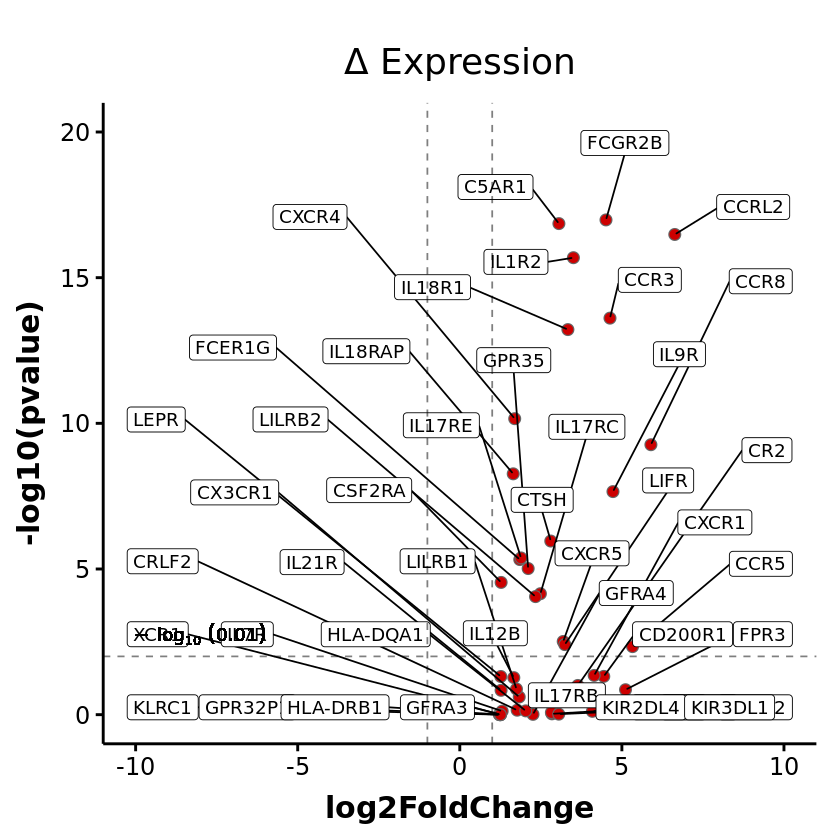

In [13]:
vol

In [4]:
# ggsave(
#     'plots/volcano_delta_te.pdf', plot = vol, 
#     device = 'pdf', width = 5, height=5.5, dpi = 300
# )

### heatmap

In [4]:
library(pheatmap)
library(RColorBrewer)

heat_colors <- brewer.pal(n = 6, name = "RdYlBu") %>% rev
greens <- brewer.pal(n = 9, name = "Greens")

In [5]:
ncu = read.table(
    'exp/deseq2_norm.txt', sep="\t"#, col.names=TRUE
)

In [6]:
ann_colors = list(
    cond = c('DMSO'="grey90", 'Decitabine'="darkorchid"),
    time = c('120h'= greens[6], '72h'=greens[4], '6h'=greens[2])
)

In [7]:
# meta 
lines   <- c(rep('hl60',12),lapply(c('kg1', 'molm14', 'ociaml2', 'ociaml3', 'thp1'), rep, 6) %>% unlist)

# meta 
conds  <- factor(c(
    # hl60
    rep(c(rep('Decitabine',2),rep('DMSO',2)),3),
    # 5 other cell lines
    rep(c(rep('Decitabine',3), rep('DMSO',3)),5)
), levels = c('DMSO','Decitabine'))

reps <- factor(c(
    # hl60
    rep(c('rep1','rep2'),6),
    # 5 other cell lines
    rep(c('rep1','rep2','rep3'),10)
),c('rep1','rep2','rep3'))

hours <- factor(c(
    # hl60
    c(rep('120h',4),rep('6h',4),rep('72h',4)), 
    # 5 other cell lines
    rep('72h',30)
),c('6h','72h','120h') )

colData <- data.frame(
    line=lines, 
    cond=conds,
    time=hours,
    reps=reps,
    row.names=colnames(ncu)[-1],
    stringsAsFactors=FALSE
)
# colData

In [15]:
plot_a_heatmap <- function(labels,go_name){
    mat <- ncu[
        # subset to selected genes 
        ncu$name %in% labels, 
        # subset normalized counts
        c('name',colData[colData$line=='hl60',c('cond','time')] %>% arrange(cond,time) %>% rownames)
    ] %>%  remove_rownames %>% column_to_rownames('name') 

    mat[rowSums(mat > 8) > 2,] %>% 
    # tibble::rownames_to_column() %>%    
    # pivot_longer(-rowname) %>%    
    # pivot_wider(names_from=rowname, values_from=value)  %>% 
    # summary
        # generate heatmap
        pheatmap(
            color = heat_colors, 
            show_colnames = F,
            # show_rownames = F,
            cutree_rows = 1,
            main = paste0('RNA expression\nHL-60 cell line\n',go_name),
            annotation = colData[colData$line=='hl60',c('cond','time')],
            cluster_rows = T, 
            cluster_cols = F, 
            scale = 'row',
            cellheight=15,
            angle_col= 45,
            annotation_colors = ann_colors
    )
    # -> hm_hl60_labels
    # # # https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
    # # pdf('exp/plots/heatmap_clustering_hl60_target_genes.pdf', width=4, height=4)
    # # grid::grid.newpage()
    # # grid::grid.draw(hm_hl60_labels$gtable)
    # # dev.off()
}

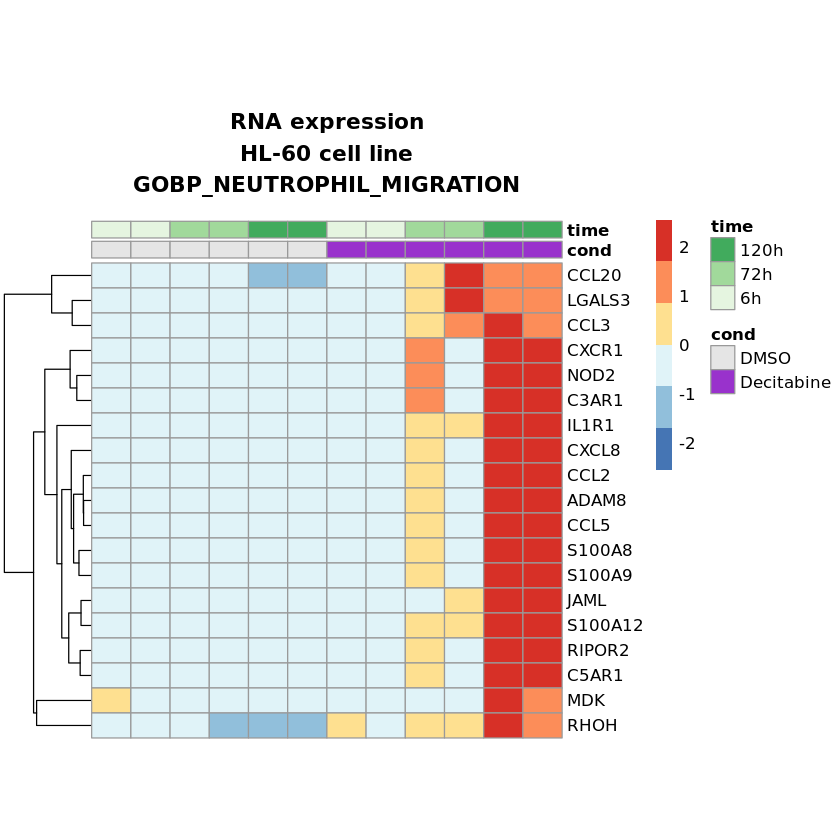

In [24]:
plot_a_heatmap(labels[['GOBP_NEUTROPHIL_MIGRATION']],'GOBP_NEUTROPHIL_MIGRATION')

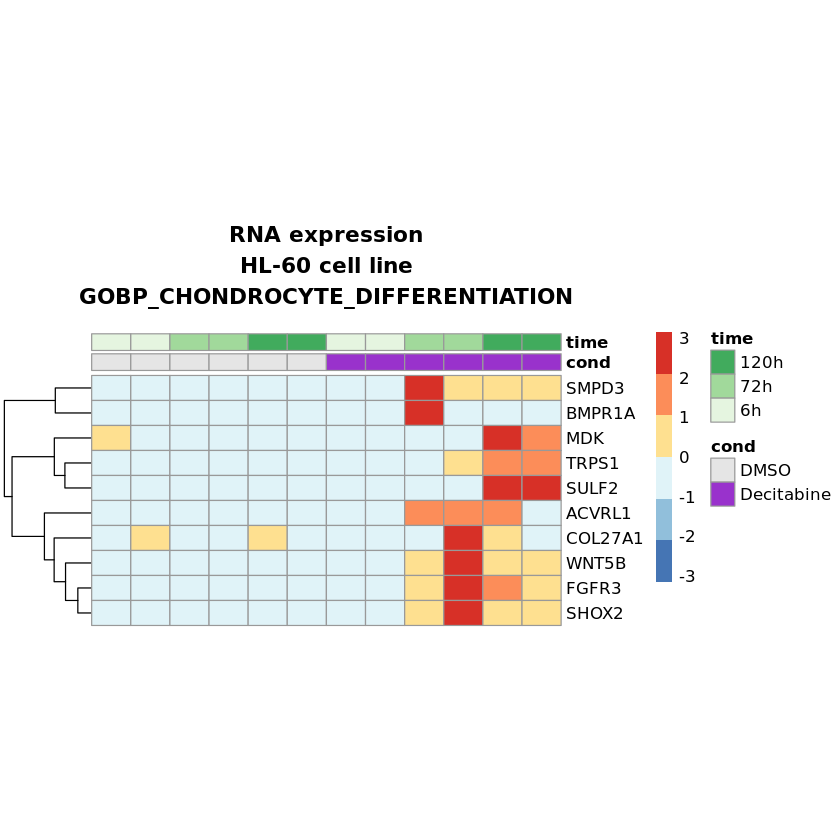

In [25]:
plot_a_heatmap(labels[['GOBP_CHONDROCYTE_DIFFERENTIATION']],'GOBP_CHONDROCYTE_DIFFERENTIATION')

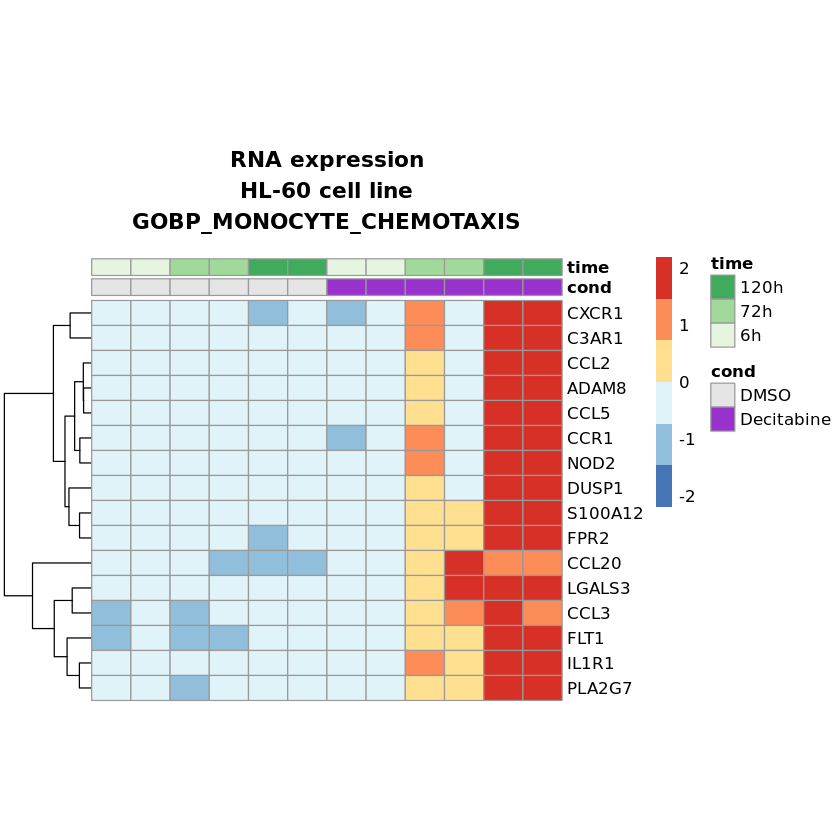

In [27]:
go_name = "GOBP_MONOCYTE_CHEMOTAXIS"

plot_a_heatmap(labels[[go_name]],go_name)

In [17]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] forcats_0.5.1   stringr_1.4.0   dplyr_1.0.7     purrr_0.3.4    
 [5] readr_2.0.2     tidyr_1.1.4     tibble_3.1.6    tidyverse_1.3.1
 [9] ggrepel_0.9.1   ggthemes_4.2.4  ggplot2_3.3.5  

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-6     tidyselect_1.1.1 repr_1.1.3      

In [28]:
date()

[1] "Wed Oct 26 18:27:47 2022"